In [102]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
import itertools
# from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.patheffects as pe
%matplotlib notebook

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline
%config IPCompleter.greedy=True

import scipy
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
# from sklearn.externals 
import joblib
from matplotlib import cm

import matplotlib as mpl
mpl.rcParams["mathtext.default"] = 'regular'

from scipy import stats
import statsmodels.api as sm

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
def Performance(ax,title,target,verbose,lim=None):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
            yerr=target.level_best['SE'].values*target.Rule,color='grey',
            alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.Rule,
           color='red',alpha = 1,label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule])
    plt.sca(ax)
    plt.grid()
    if lim is not None:
        ax.set_xlim(lim)
        yaxy.set_xlim(lim)
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        print(i,mod)
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
    else:
#         alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',alpha = 1,label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',alpha = 1,label='Parsimony')
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
    ax.grid()
    print(Data)

def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    print(target.params['target'],target.params['Inputs'],
                       target.params['Spath'])
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                       ScalePath=target.params['Spath'],Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                   ScalePath=target.params['Spath'],Project=True,fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
#     print(AllData[name])
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)

class ResultMap:
    def __init__(self,Path,target,Test='N/A',Rule=1,alpha = .025,DataName ='AllData.csv', AltPath=None,Site='FishIsland',FPVars=None):
        self.FPVars = FPVars
        self.target = target        
        self.params = Dense.Params(Path,'Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,DataName,FPVars = FPVars)
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += target+'/'
        else:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+AltPath+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'           
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Nodes'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        self.Best = self.Records.loc[self.Records.index==Rule]
        self.Model_Selection = self.Best['Model'].values[0]
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        self.Weights=[]
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.Best['K'].values[0]))):
                prog1.value+=1
                Y = results[0]
                self.Weights.append(results[1])
#                 print(Y)
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        YTru = self.RST.y+0.0
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        
        for k in range(0,1):
            results=Dense.Load_Model(k,X=X,params=self.params)
            YVar = results[0]
            YVar = YStandard.inverse_transform(YVar)                    
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar
        
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4']:#,'ER']:
        try:
            AllRes[f]={}
            AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
            AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
            AllRes[f]['Derivatives']={}
            AllRes[f]['SSQ'] ={}
            AllRes[f]['X'] = {}
            AllRes[f]['Yhat'] = {}
            AllRes[f]['Ytrue'] = {}
            AllRes[f]['Outputs'] = {}
        except:
            pass
    return(AllRes)

def DerivKeys(Resluts,col): 
    i =0
    Keys = {}
    for f,r in zip(Results.Factors.values,Results[col].values):
        if r > 0:
            Keys[f]=i
            i += 1
    return(Keys)


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Path = 'C:\\Users\\wesle\\NetworkAnalysis\\'

Site = 'FishIsland_NDVI/'
Site = 'FishIsland/'
Path = Path+Site
AllRes = RecRead(Path = Path) 
cm_2_in=1/2.54 


In [103]:
for i,F in enumerate(['fco2','fch4']):
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
#     print(Records['Remove'])
    MBE = []
    MBEs = []
    RMSE = []
    RMSEs = []
    r2 = []
    SDev = []

    for I in Records.index:
        
        y = np.load(Path+F+'_Yhat_'+I+'.npy')#.mean(axis=0)
        x = np.load(Path+F+'_Ytrue_'+I+'.npy')#.mean(axis=0)
        K = y.shape[0]
        df = pd.DataFrame(data={'target':y.flatten(),'y':x.flatten()}).dropna()

        mbe = (np.nansum((x-y),axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))
        MBEs.append(mbe.std())

        rmse = (np.nansum((x-y)**2,axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))**.5
        RMSEs.append(rmse.std())

        MBE.append((df['y']-df['target']).sum()/df['y'].count())
        SDev.append(np.abs(df['y']-df['target']).sum()/df['y'].count()*2**.5)
        RMSE.append(metrics.mean_squared_error(df['y'],df['target'])**.5)
        r2.append(metrics.r2_score(df['y'],df['target']))

    RMSEs=np.array(RMSEs)
    MBEs=np.array(MBEs)

    df = pd.DataFrame(index = Records.index,data = {'RMSE':RMSE,'SE':RMSEs/(K**.5),'MBE':MBE,'MBESE':MBEs/(K**.5),'R2':r2})
    df['Diff']=df['RMSE'].diff()
    Xlbls = []
    df = df.iloc[::-1]
#     df['Factor']=Xlbls[::-1]
    
    Mn = (df.loc[df['RMSE']==df['RMSE'].min()])
    Mn = (df.loc[df['R2']==df['R2'].max()])
    df['PCT'] = Mn['RMSE'].values[0]/df['RMSE']
    
#     print(Mn[['Factor','R2','RMSE','Diff','MBE']].round(3))
    df['MX']=df['RMSE']+df['SE']
    df['RMSE_MX']=df['MX']-df['RMSE']
    print(df[['R2','RMSE','SE','MX','RMSE_MX']].round(3)[::-1])
    

          R2   RMSE     SE     MX  RMSE_MX
21_75  0.946  0.347  0.003  0.350    0.003
8_75   0.931  0.393  0.002  0.395    0.002
          R2   RMSE     SE     MX  RMSE_MX
21_43  0.743  6.384  0.046  6.430    0.046
8_43   0.731  6.534  0.047  6.581    0.047


In [104]:
DataName = 'AWS_FI_RF.csv'
co2_Model_Index = '8_75'
ch4_Model_Index = '8_43'   
fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName=DataName,Site=Site)
fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=DataName,Site=Site)
ER = ResultMap(Path,'ER',Test='N/A',Rule=co2_Model_Index,DataName=DataName,Site=Site,AltPath='fco2')
fch4_FP = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=DataName,Site=Site)
T30 = fco2.RST.Master.copy()
T30 = T30.loc[T30.index.year>2008].copy()
T30 = T30.loc[T30.index.year<2020].copy()
mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':1#,#(1e-9 * 12.0107 *1800)
       }

In [105]:

# T30_FP['Polygon'] = .8#T30_FP['Polygon_Obs'].median()
# T30_FP['Rim'] = .1#T30_FP['Rim_Obs'].median()

# T30_FP['Polygon'].mean()

In [106]:
T30 = Mapper(T30,fch4,'NME_est',Fill = False)
T30 = Mapper(T30,fco2,'NEE_est',Fill = False)

T30_Dark = T30.copy()
T30_Dark['PPFD_Avg'] = 0
T30_Dark['Daytime'] = 0


T30_FP = T30.copy()
T30_FP['Polygon'] = T30_FP['Polygon_Obs']
T30_FP['Rim'] = T30_FP['Rim_Obs']

T30 = Mapper(T30,fch4_FP,'NME_est_FP',Fill = False,DarkTarget=T30_FP)
T30 = Mapper(T30,ER,'ER_est',Fill = False,DarkTarget=T30_Dark)

print(T30)

fch4 ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim'] C:\Users\wesle\NetworkAnalysis/FishIsland//fch4/8_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

fco2 ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/8_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

fch4 ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim'] C:\Users\wesle\NetworkAnalysis/FishIsland//fch4/8_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

ER ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/8_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

                                datetime  fch4  fco2  ch4_flux  co2_flux  ER  \
datetime                                                                       
2009-05-01 00:00:00  2009-05-01 00:00:00   NaN   NaN       NaN       NaN NaN   
2009-05-01 01:00:00  2009-05-01 01:00:00   NaN   NaN       NaN       NaN NaN   
2009-05-01 02:00:00  2009-05-01 02:00:00   NaN   NaN       NaN       NaN NaN   
2009-05-01 03:00:00  2009-05-01 03:00:00   NaN   NaN       NaN       NaN NaN   
2009-05-01 04:00:00  2009-05-01 04:00:00   NaN   NaN       NaN       NaN NaN   
...                                  ...   ...   ...       ...       ...  ..   
2019-10-31 19:00:00  2019-10-31 19:00:00   NaN   NaN       NaN       NaN NaN   
2019-10-31 20:00:00  2019-10-31 20:00:00   NaN   NaN       NaN       NaN NaN   
2019-10-31 21:00:00  2019-10-31 21:00:00   NaN   NaN       NaN       NaN NaN   
2019-10-31 22:00:00  2019-10-31 22:00:00   NaN   NaN       NaN       NaN NaN   
2019-10-31 23:00:00  2019-10-31 23:00:00

In [107]:
mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':1#,#(1e-9 * 12.0107 *1800)
       }

for target,name in zip([fch4,fco2,ER,fch4_FP],['NME','NEE','ER','NME_FP']):
    target.cols = []
#     print(target)
#     print(T30.shape, target.Y_fill[0,:].shape)
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)*mult[target.target]
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

Cols=[]
for i in range(target.Y_fill.shape[0]):
    T30['CBal_'+str(i)]=T30['NME_'+str(i)]*mult['fch4']+T30['NEE_'+str(i)]*mult['fco2']
    Cols.append('CBal_'+str(i))
    
T30['CBal'] = T30[Cols].mean(axis=1)

for target,name in zip([fch4,fco2,ER,fch4_FP],['NME_est','NEE_est','ER_est','NME_est_FP']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()

Done


In [108]:
def MI(Data,Vars,JustBetween=False):
#     print()
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)
T30['DOY']=T30.index.dayofyear

Start = 174
End = 256

LongBean_Start = 100
LongBean_End = 300

NDVI_Thresh = 0.388104
NDVI_Thresh = 0.244049
for Y in range(2009,2020):
    Estimates = []
    CIs = []
    SE = []
    IntType = []
    Scale = []
    Samples = []
    Fluxes = []
    Type = []
    Targets = {'NEE':fco2,
               'NME':fch4,
               'NEE_est':fco2,
               'NME_est':fch4,
               'NME_est_FP':fch4_FP,
           'ER_est':ER,
#            'ER':ER
              }
    Temp = T30.loc[(T30['DOY']>=Start)&(T30['DOY']<=End)&(T30.index.year==Y)]
#     Temp = T30.loc[#(T30['NDVI']>NDVI_Thresh)&
#                    (T30['DSSM']>0)&(T30.index.year==Y)]
    Vars = ['NEE_est','NME_est','NME_est_FP']
#     if Y >=2012:
#         Vars.append('NME')
    for Var in Vars:
        target = Targets[Var]
        if Var == 'NEE_est' or Var == 'NME_est' or Var == 'ER_est' or Var == 'NME_est_FP':
            CIPI = 'CI'
            if Var != 'NME_est_FP':
                Fluxes.append(Var.split('_')[0])
            else:
                Fluxes.append('NME_FP')
            
            Type.append('EC Obs.')
            std = MI(Temp,target.cols)**.5*1*mult[target.target]
            Int=Temp[Var+'_CI'].mean()#(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())
            
        SE.append(std)
        U = Temp[Var].sum()/(Temp.shape[0]/1)#*mult[target.target]
        Estimates.append(U)
        CIs.append(Int)
        Scale.append('Footprint')
        Samples.append(Temp[Var].count())
        IntType.append(CIPI)
    std = MI(Temp,Cols)**.5
    Int = (std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp['CBal'].count())
    Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
            '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}
    if Y == 2009:
        All = pd.DataFrame(data = Data)
#         All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]
        All['Year'] = Y
    else:
        More = pd.DataFrame(data = Data)
#         More[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]
        More['Year'] = Y
        All = All.append(More)
#         All = All.reset_index()

All = All.reset_index()

All = All.loc[((((All['Flux']=='NME')|(All['Flux']=='NME_FP'))&(All['Year']!=2009))|(All['Flux']=='NEE'))].copy()
# print(All.loc[All['Flux']=='NEE'])
# print(All.index.values)
All.to_csv('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Annual_est.csv')
All.loc[All['Flux']=='NME'].sort_values(by='Estimates')

All['CI_Min']=All['Estimates']-All['95% CI/PI']
All['CI_Max']=All['Estimates']+All['95% CI/PI']
All[['Year','Estimates','95% CI/PI','Flux','CI_Min','CI_Max']].set_index(['Flux','Year']).to_csv('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Annual_est.csv')
NEE = All.loc[All['Flux']=='NEE']
NME = All.loc[All['Flux']=='NME']
print(NEE.loc[NEE['Estimates']==NEE['Estimates'].max(),['Estimates','95% CI/PI','CI_Min','CI_Max']])
print(NEE.loc[NEE['Estimates']==NEE['Estimates'].min(),['Estimates','95% CI/PI','CI_Min','CI_Max']])
print()
print(NME.loc[NME['Estimates']==NME['Estimates'].max(),['Estimates','95% CI/PI','CI_Min','CI_Max']])
print(NME.loc[NME['Estimates']==NME['Estimates'].min(),['Estimates','95% CI/PI','CI_Min','CI_Max']])

    Estimates  95% CI/PI   CI_Min    CI_Max
27  -0.466843   0.455937 -0.92278 -0.010906
   Estimates  95% CI/PI    CI_Min   CI_Max
6  -0.642517   0.369156 -1.011673 -0.27336

    Estimates  95% CI/PI    CI_Min     CI_Max
13  29.395806   4.175686  25.22012  33.571492
    Estimates  95% CI/PI     CI_Min     CI_Max
28  26.605339   5.362585  21.242754  31.967925


In [109]:

GS = T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
             (T30.index.year>2008)&(T30.index.year<2020))]
print(GS['NME_est'].mean(),GS['NME_est_CI'].mean())
print(GS['NEE_est'].mean(),GS['NEE_est_CI'].mean())

27.92172622680664 4.7506879214958175
-0.5849668979644775 0.41205021276251164


## Validation

In [110]:
FSO = pd.read_csv('Skeeter_et_al_2022.csv',index_col=['datetime']).drop('Unnamed: 0',axis=1).drop('datetime.1',axis=1)

import pytz
Mt = pytz.timezone('Canada/Mountain')
FSO = FSO.set_index(pd.to_datetime(FSO.index, utc=True)).tz_convert(Mt)
FSOH = FSO[['fco2','fch4','NEE_est','NME_est']].resample('H').agg(pd.Series.mean,skipna=False)
FSOH = FSOH.rename(columns={'NEE_est':'NEE_FSO',
                            'NME_est':'NME_FSO'})
idx = FSOH.index.rename('datetime')
FSOH=FSOH.set_index(idx.tz_localize(None))
FSOH = FSOH.join(T30[['NEE_est','NME_est','NME_est_FP']],how='inner')
FSOH
# GS.index

,fco2,fch4,NEE_FSO,NME_FSO,NEE_est,NME_est,NME_est_FP
datetime,,,,,,,
2017-06-23 00:00:00,0.230095,23.356519,-0.099997,21.482391,0.334312,23.180927,22.351751
2017-06-23 01:00:00,0.589742,25.337483,0.581670,17.478934,1.069093,19.803343,18.468473
2017-06-23 02:00:00,0.588945,28.771406,0.734591,21.390413,1.171150,18.417906,17.172375
2017-06-23 03:00:00,1.066016,NaN,1.047844,22.957576,1.336305,23.520535,22.728275
2017-06-23 04:00:00,NaN,NaN,1.035161,20.133578,1.264426,23.830914,24.710955
...,...,...,...,...,...,...,...
2017-09-13 08:00:00,0.419933,7.019717,0.818862,11.551012,0.668809,9.020825,11.380938
2017-09-13 09:00:00,0.238773,15.656314,0.320697,14.705811,0.723859,13.863904,17.348429
2017-09-13 10:00:00,-0.063597,17.087225,0.042180,17.755456,0.135774,15.935381,19.480429


In [111]:
X = 'fch4'
X2 = 'NME_FSO'
y = 'NME_est_FP'

X = 'fco2'
X2 = 'NEE_FSO'
y = 'NEE_est'


DNA=(FSOH[[X,y,X2]].dropna())
print('r2',(metrics.r2_score(DNA[X],DNA[y])*100).round(2))
print('RMSE',(metrics.mean_squared_error(DNA[X],DNA[y])**.5).round(2))
print('MAE',(metrics.mean_absolute_error(DNA[X],DNA[y])).round(2))
# print((metrics.mean_bias_error(DNA[X],DNA[y])).round(2))

X2 = sm.add_constant(DNA[X])
est = sm.OLS(DNA[y], X2)
est2 = est.fit()
print(est2.summary())
# with open('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/'+X[0]+'_v_'+y+'_summary.txt', 'w') as fh:
#     fh.write(est2.summary().as_text())


r2 92.59
RMSE 0.4
MAE 0.3
                            OLS Regression Results                            
Dep. Variable:                NEE_est   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 1.458e+04
Date:                Sun, 06 Feb 2022   Prob (F-statistic):               0.00
Time:                        18:00:03   Log-Likelihood:                -541.45
No. Observations:                1168   AIC:                             1087.
Df Residuals:                    1166   BIC:                             1097.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0800     

## Satelite

In [112]:

GPP = pd.read_csv('G:\\My Drive\\earthengine/GPP_Multi_Scale.csv',
                  parse_dates=['date'],na_values=-9999,index_col=['date']).dropna()
GPP = GPP.set_index(pd.to_datetime(GPP.index))
# GPP = GPP.resample('1D').interpolate()/8

PsnNet = pd.read_csv('G:\\My Drive\\earthengine/PsnNet.csv',
                  parse_dates=['date'],na_values=-9999,index_col=['date']).dropna()
PsnNet = PsnNet.set_index(pd.to_datetime(PsnNet.index))

NDVI = pd.read_csv('G:\\My Drive\\earthengine/NDVI_NBAR_FP_New.csv',
                  parse_dates=['date'],na_values=-9999,index_col=['date']).dropna()
NDVI = NDVI.set_index(pd.to_datetime(NDVI.index))

GPP['RSMP_Key'] = GPP.index.copy()
NDVI['RSMP_Key2'] = NDVI.index.copy()

Test = T30.join(NDVI,how='outer',rsuffix='R').join(GPP,how='outer',rsuffix='R').join(PsnNet,how='outer',rsuffix='R')
Test = Test.loc[((Test.index.year>2008)&(Test.index.year<2020))]


Test['RSMP_Key']=Test['RSMP_Key'].ffill()

Test2 = Test.groupby('RSMP_Key').mean()

Test2['ndvi_diff']=Test2['ndvi_FIR'].diff()

Test3=Test2.loc[((Test2.index.dayofyear>=174)&
          (Test2.index.dayofyear<=256-7))]


# X = 
y = 'NEE_est'

for X,y in zip(['ndvi_diff','GPP_FIR','ndvi_diff'],['NEE_est','NEE_est','NME_est']):
    DNA = Test3[[X,y]].dropna()
    X2 = sm.add_constant(DNA[X])
    est = sm.OLS(DNA[y], X2)
    est2 = est.fit()
    print()
    print(X)
    print(stats.pearsonr(DNA[X], DNA[y]))
    print(est2.summary())
    with open('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/'+X+'v'+y+'_summary.txt', 'w') as fh:
        fh.write(est2.summary().as_text())


Test['RSMP_Key']=Test['RSMP_Key'].ffill()

Test4 = Test.groupby('RSMP_Key').mean()

X = ['ndvi_FIR','ndvi_diff']
X = ['ndvi_FIR']
# X = ['ndvi_diff']
# X = ['GPP_FIR']
DNA = Test3[X+[y]].dropna()
X2 = sm.add_constant(DNA[X])
est = sm.OLS(DNA[y], X2)
est2 = est.fit()
print(metrics.mean_squared_error(DNA[y],est2.predict(X2)))
print()
print(X)
print(est2.summary())
# with open('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/'+X+'v'+y+'_summary.txt', 'w') as fh:
#     fh.write(est2.summary().as_text())


ndvi_diff
(-0.6278948342322068, 2.1097693326902595e-13)
                            OLS Regression Results                            
Dep. Variable:                NEE_est   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     70.29
Date:                Sun, 06 Feb 2022   Prob (F-statistic):           2.11e-13
Time:                        18:00:05   Log-Likelihood:                -39.751
No. Observations:                 110   AIC:                             83.50
Df Residuals:                     108   BIC:                             88.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

In [113]:

T30.loc[((T30.index.month==7)&(T30.index.year<2016)),['NEE_est','NME_est']].mean()

NEE_est    -0.982035
NME_est    34.030773
dtype: float32

In [114]:

GS = T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
             (T30.index.year>2008)&(T30.index.year<2020))].copy()


Non_Inputs=['NEE_est','NME_est',
            'GPP_FI','ndvi_FI',
#             'ndvi_diff'#,'GPP_diff'
           ]

Sat_Data = ['GPP_FI',
       'GPP_FP', 'ndvi_FI', 'ndvi_FP']

BU = T30[Sat_Data].copy()
T30[Sat_Data]=T30[Sat_Data].interpolate()
# T30['ndvi_diff']=T30['ndvi_FI'].diff(24)
# T30['GPP_diff']=T30['GPP_FI'].diff(24)
# GS['ndvi_diff']=T30['ndvi_FI'].diff(24)
# GS['GPP_diff']=T30['GPP_FI'].diff(24)

Annual = GS[Non_Inputs].groupby(GS.index.year).mean()
Annual['ndvi_FI_max'] = GS['ndvi_FI'].groupby(GS.index.year).max()

Day8 = GS[Non_Inputs].resample('8D').mean()
Day8['ndvi_diff'] = Day8['ndvi_FI'].diff()

D8 = Day8.copy()
D8 = D8.loc[((D8.index.dayofyear>=Start)&(D8.index.dayofyear<=End)&
        (D8.index.year>=2009)&(D8.index.year<=2018)),Non_Inputs
       ].corr()[['NEE_est','NME_est']][2:]

# D = GS.resample('D').mean()

Day = GS[Non_Inputs].resample('D').mean()
Day['ndvi_diff']=Day['ndvi_FI'].diff()
D = Day.corr()[['NEE_est','NME_est']][2:]

L7 = pd.read_csv('FP_Landsat7.csv',parse_dates=['system:time_start'],index_col=['system:time_start']).resample('Y').max()
L7.index=L7.index.year
L8 = pd.read_csv('FP_Landsat8.csv',parse_dates=['system:time_start'],index_col=['system:time_start']).resample('Y').max()
L8.index=L8.index.year

print((Annual.join(L8).corr()**2)[['NEE_est','NME_est','NDVI_LS8']].round(2))
# print((Annual.join(L7).corr()**2)[['NEE_est','NME_est','NDVI_LS7']].round(2))

Annual= Annual.join(L7,how='inner')#.join(L8,how='outer').

A = Annual.corr()[['NEE_est','NME_est']][2:]
print((A**2).round(2)*np.sign(A))
print((D8**2).round(2)*np.sign(D8))
print((D**2).round(2)*np.sign(D))

Annual= Annual.join(L8,how='outer')

             NEE_est  NME_est  NDVI_LS8
NEE_est         1.00     0.08      0.10
NME_est         0.08     1.00      0.00
GPP_FI          0.15     0.07      0.04
ndvi_FI         0.01     0.00      0.02
ndvi_FI_max     0.03     0.00      0.06
NDVI_LS8        0.10     0.00      1.00
             NEE_est  NME_est
GPP_FI         -0.15     0.07
ndvi_FI        -0.01     0.00
ndvi_FI_max    -0.03     0.00
NDVI_LS7        0.06    -0.02
         NEE_est  NME_est
GPP_FI     -0.56     0.55
ndvi_FI    -0.20     0.05
           NEE_est  NME_est
GPP_FI       -0.33     0.46
ndvi_FI      -0.09     0.02
ndvi_diff    -0.04     0.08


<IPython.core.display.Javascript object>


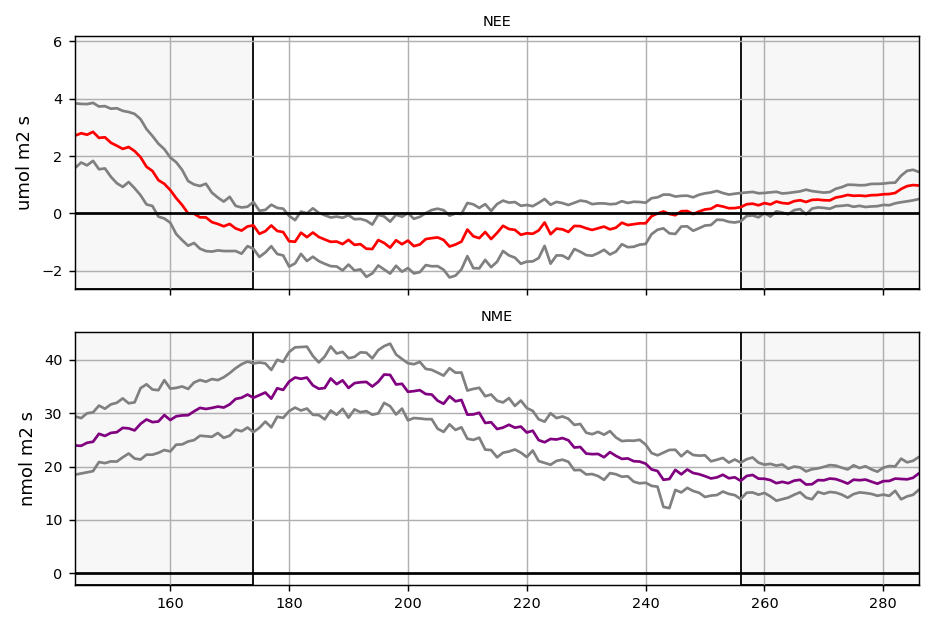

NEE
174 256 -2.6258381605148315 6.162118315696716
NME
174 256 -2.153135299682617 45.21584129333496


In [115]:
fig,axes=plt.subplots(2,figsize=(18.2*cm_2_in, 12.2*cm_2_in),sharex=True)
Yearly = T30[['NEE_est','NME_est']].groupby(T30.index.dayofyear).mean()
Annual_S = T30[['NEE_est','NME_est']].groupby(T30.index.dayofyear).std()#.rolling(8).mean()
ax=axes[0]
ax.plot(Yearly['NEE_est']+Annual_S['NEE_est']/11**.5*stats.t.ppf(1-0.025,11),color='grey')
ax.plot(Yearly['NEE_est']-Annual_S['NEE_est']/11**.5*stats.t.ppf(1-0.025,11),color='grey')
ax.plot(Yearly['NEE_est'],color='red')

ax=axes[1]
ax.plot(Yearly['NME_est']+Annual_S['NME_est']/10**.5*stats.t.ppf(1-0.025,10),color='grey')
ax.plot(Yearly['NME_est']-Annual_S['NME_est']/10**.5*stats.t.ppf(1-0.025,10),color='grey')
ax.plot(Yearly['NME_est'],color='purple')

Variables = ['NEE_est',
'NME_est','C']

Aliases = ['NEE',
'NME','Net C Balance']

Units = ['umol m2 s',
'nmol m2 s',
'G'
]

j=0
Xl1,Xl2=Start-30,End+30

axes[0].plot([Xl1,Xl2],[0,0],color='k')
axes[1].plot([Xl1,Xl2],[0,0],color='k')
for ax in axes:
#     for ax in axe:
    ax.axvspan(Xl1-1,Start,facecolor=[.97,.97,.97],edgecolor='k')
    ax.axvspan(End,Xl2+1,facecolor=[.97,.97,.97],edgecolor='k')
    ax.set_xlim(Xl1,Xl2)
    ax.grid()
    ax.set_title(Aliases[j])
    ax.set_ylabel(Units[j])
    yl = ax.get_ylim()
    print(Aliases[j])
    print(Start,End,yl[0],yl[1])
    ax.set_xlim(Xl1,Xl2)
        

    j+=1
plt.tight_layout()

plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Fluxes.png')

In [116]:


X=['NEE_est']
y='NME_est'
DNA = GS[X+[y]].resample('D').mean().dropna()

X2 = sm.add_constant(DNA[X])
est = sm.OLS(DNA[y], X2)
est2 = est.fit()
print(est2.summary())

with open('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/'+X[0]+'_v_'+y+'_summary.txt', 'w') as fh:
    fh.write(est2.summary().as_text())

# stats.spearmanr(DNA[y],DNA[X[0]])

                            OLS Regression Results                            
Dep. Variable:                NME_est   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     652.7
Date:                Sun, 06 Feb 2022   Prob (F-statistic):          5.47e-109
Time:                        18:00:06   Log-Likelihood:                -2913.2
No. Observations:                 913   AIC:                             5830.
Df Residuals:                     911   BIC:                             5840.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.7029      0.282     80.417      0.0

<IPython.core.display.Javascript object>


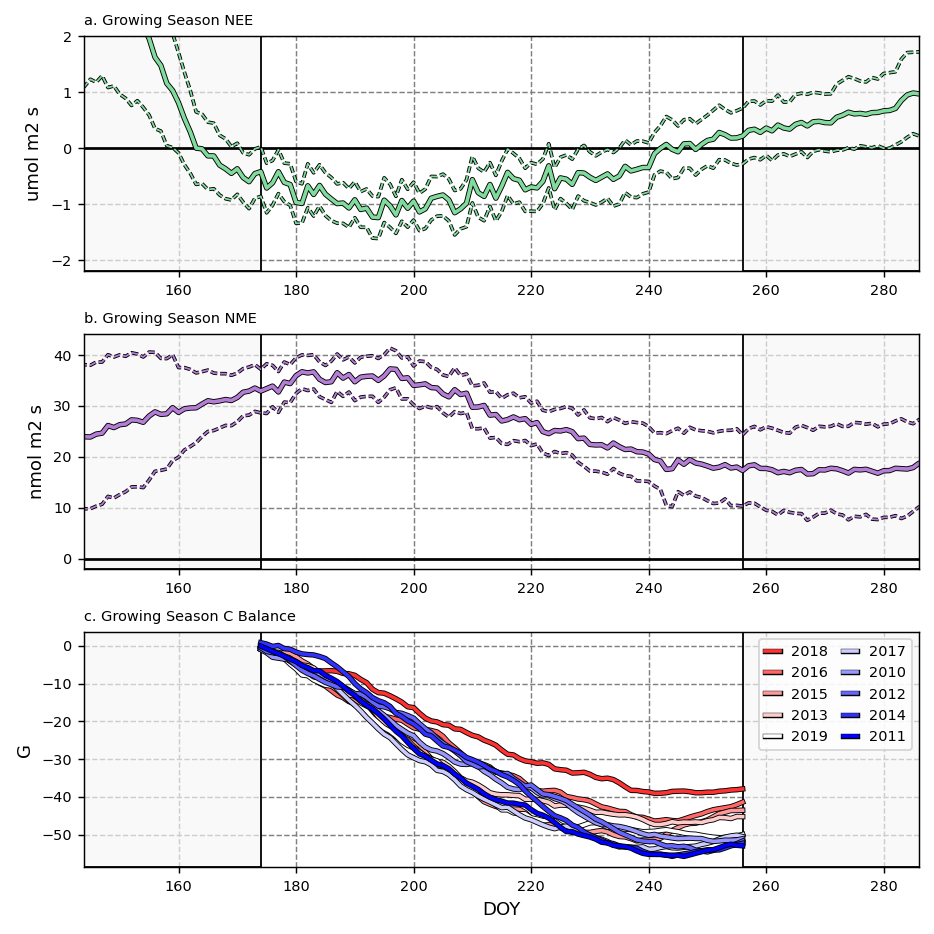

count    10.000000
mean      0.048501
std       0.005116
min       0.042295
25%       0.044460
50%       0.046678
75%       0.052649
max       0.056990
Name: Frac, dtype: float64
            Max  Max_Date      Total        CO2       CH4      Frac
2011 -55.811019       246 -53.000059 -55.340685  2.340625  0.042295
2014 -55.796469       244 -52.325655 -54.751932  2.426277  0.044314
2012 -54.620213       250 -51.746854 -54.217492  2.470638  0.045569
2010 -51.813105       251 -51.127044 -53.483525  2.356481  0.044060
2017 -53.935449       240 -50.554349 -52.930835  2.376486  0.044898
2019 -50.874025       252 -49.986515 -52.495072  2.508557  0.047787
2013 -47.351951       242 -45.253718 -47.785612  2.531894  0.052984
2015 -51.693494       238 -43.569430 -45.941902  2.372473  0.051641
2016 -46.446073       241 -41.429849 -43.816667  2.386819  0.054473
2018 -39.086347       241 -37.918160 -40.209708  2.291548  0.056990
24   -0.614538
Name: Estimates, dtype: float64
24    0.286286
Name: 95% C

In [117]:

Yearly = T30[['NEE_est','NME_est','NEE_est_CI','NME_est_CI','GPP_FI']].groupby(T30.index.dayofyear).mean()
import matplotlib.patheffects as pe

fig,axes = plt.subplots(3,figsize=(18.2*cm_2_in, 18.2*cm_2_in))


GS = T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
             (T30.index.year>2008)&(T30.index.year<2020))].copy()

nee = All.loc[All['Flux']=='NEE']

nme = All.loc[All['Flux']=='NME']

ax=axes[2]
# ax2=axes[1,1]

norm = mpl.colors.Normalize(vmin=0, vmax=10)
Colors = []
for i in range(0,10):
    rgba_color = cm.bwr(norm(i)) 
    Colors.append(rgba_color)

mult = {'fco2':(1e-6 * 12.0107 *3600),
        'fch4':(1e-9 * 12.0107 *3600)
       }

GS['NEE_est_c'] = GS['NEE_est']*mult['fco2']
GS['NME_est_c'] = GS['NME_est']*mult['fch4']
GS['C']=GS['NEE_est_c']+GS['NME_est_c']

Yz = GS.loc[GS.index.year>=2010].resample('Y').sum()['C'].sort_values()
# print(Yz)
# print((Yz.index.year).values)
i = Yz.index.year.shape[0]-1
Mx,Pd,Sm,CO,CH = [],[],[],[],[]
Yix = []
for y in Yz.index.year[::-1]:
    if y >=2009 and y<=2019:
        Yix.append(y)
        Year = GS.loc[GS.index.year==y,['C','NEE_est_c','NME_est_c']].resample('D').sum().cumsum().copy()
        Mx.append(Year['C'].min())
        Pd.append(Year.loc[Year['C']==Year['C'].min()].index.dayofyear.values[0])
        Sm.append(Year['C'][-1:].values[0])
        ax.plot(Year.index.dayofyear,Year['C'],color=Colors[i],label=y,lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
        
        CO.append(Year['NEE_est_c'][-1:].values[0])
        CH.append(Year['NME_est_c'][-1:].values[0])
        
        i -=1
Cbal = pd.DataFrame(index=Yix,data={'Max':Mx,'Max_Date':Pd,'Total':Sm,'CO2':CO,'CH4':CH})
Cbal['Frac'] = Cbal['CH4']/Cbal['CO2'].abs()
print(Cbal['Frac'].describe())
print(Cbal.sort_values(by='Total'))

ax.grid()
ax.set_title('c. Growing Season C Balance',loc='left')
ax.set_ylabel('g C $m^{-2}$')
ax.set_xlabel('DOY')
ax.set_xlim(Start,End)
ax.legend(ncol=2,columnspacing=1,handlelength=1)

# ax.legend()
ax=axes[0]
ax.set_title('a. Growing Season NEE',loc='left')

ax=axes[1]
ax.set_title('b. Growing Season NME',loc='left')

j=0
Xl1,Xl2=Start-30,End+30

axes[0].plot([Xl1,Xl2],[0,0],color='k')
axes[1].plot([Xl1,Xl2],[0,0],color='k')
ax=axes[0]

ax.plot(Yearly['NEE_est']-Yearly['NEE_est_CI'],linestyle='--',color='#81db9c',lw=1, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
ax.plot(Yearly['NEE_est']+Yearly['NEE_est_CI'],linestyle='--',color='#81db9c',lw=1, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
ax.plot(Yearly['NEE_est'],color='#81db9c',lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])

# e
ax=axes[1]
ax.plot(Yearly['NME_est']-Yearly['NME_est_CI'],linestyle='--',color='#b57ed6',lw=1, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])
ax.plot(Yearly['NME_est']+Yearly['NME_est_CI'],linestyle='--',color='#b57ed6',lw=1, path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()])

ax.plot(Yearly['NME_est'],color='#b57ed6',lw=2, path_effects=[pe.Stroke(linewidth=3, foreground='k'), pe.Normal()])
j=0
for ax in axes:#[axes[0],axes[1]]:
    ax.axvspan(Xl1-1,Start,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax.axvspan(End,Xl2+1,facecolor=[.97,.97,.97,.65],edgecolor='k')
    ax.set_xlim(Xl1,Xl2)
    ax.grid()
#     ax.set_title(Aliases[j])
    ax.set_ylabel(Units[j])
    yl = ax.get_ylim()
#     print(Aliases[j])
#     print(Start,End,yl[0],yl[1])
    ax.set_xlim(Xl1,Xl2)
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed')
    j+=1
axes[0].set_ylim(-2.2,2)

plt.tight_layout()
print(All.loc[((All['Year']==2017)&(All['Flux']=='NEE')),'Estimates'])
print(All.loc[((All['Year']==2017)&(All['Flux']=='NEE')),'95% CI/PI'])
print(All.loc[((All['Year']==2017)&(All['Flux']=='NME_FP')),'Estimates'])
print(All.loc[((All['Year']==2017)&(All['Flux']=='NME_FP')),'95% CI/PI'])
Yearly.columns.values
plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Modeled_Fluxes.jpg',dpi=600)

<IPython.core.display.Javascript object>


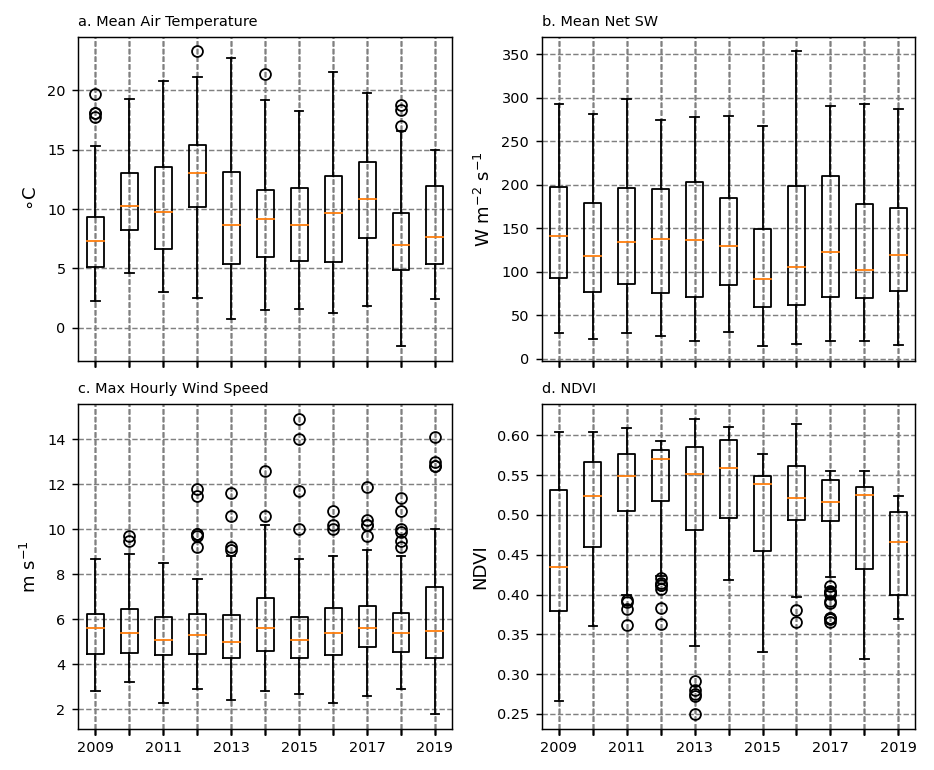

datetime
2013-09-03      1.681667
2018-09-03      8.493333
2016-09-09      8.731250
2009-08-28      9.266667
2015-08-31     11.917500
                 ...    
2017-06-23    216.681667
2018-06-30    218.605000
2016-06-23    223.769167
2011-06-25    225.937083
2016-07-27    276.615000
Name: NR_Wm2_Avg, Length: 913, dtype: float64
datetime
2016-07-27    276.615
Name: NR_Wm2_Avg, dtype: float64


In [118]:

fig,axes = plt.subplots(2,2,figsize=(18.2*cm_2_in, 15*cm_2_in),sharex=True)#, 23.7*cm_2_in))

GS = T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
             (T30.index.year>2008)&(T30.index.year<2020))].copy()

GS_y = GS.resample('Y').mean()
GS_y['Rainfall'] = GS['Rainfall'].resample('Y').sum()
GS_y['wind_speed'] = GS['wind_speed'].resample('Y').max()
GS_y['NDVI_mx'] = GS['ndvi_FI'].resample('Y').max()
GS_y['NDVI_mn'] = GS['ndvi_FI'].resample('Y').min()
GS_y['Active_Layer_1'] = GS['Active_Layer_1'].resample('Y').median()


Bx_A = []
Bx_R = []
Bx_W = []
Bx_Rn = []
Bxl = []
Bxt = []
Bx_N = []
i = 0
for y in range(2009,2020):
    Bx_A.append(GS.loc[GS.index.year==y,'Air_Temp'].resample('D').mean())
    Bx_R.append(GS.loc[GS.index.year==y,'Net_SW'].resample('D').mean())
    Bx_W.append(GS.loc[GS.index.year==y,'wind_speed'].resample('D').max())
    Bx_Rn.append(GS.loc[GS.index.year==y,'Rainfall'].resample('D').sum())
    Bx_N.append(GS.loc[GS.index.year==y,'ndvi_FI'].resample('D').mean())
#     print(y)
    Bxt.append(y-2008)
    if i == 0:
#         print('-')
        Bxl.append(y)
        i = 1
    elif i == 1:
        Bxl.append('')
        i = 0
    
GS = T30.resample('D').mean()

GS = GS.loc[((GS.index.dayofyear>=Start)&(GS.index.dayofyear<=End)&
             (GS.index.year>2008)&(GS.index.year<2020))]
    
ax = axes[0,0]
ax.boxplot(Bx_A)#,vert=False)
y1=ax.get_ylim()[1]
y0=ax.get_ylim()[0]
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
# ax.set_xticklabels(Bxl)
ax.set_ylabel('$\circ$C')
ax.set_title('a. Mean Air Temperature',loc='left')

ax = axes[0,1]
ax.boxplot(Bx_R)#,vert=False)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
# ax.set_xticklabels(Bxl)
ax.set_ylabel('W m$^{-2}$ s$^{-1}$')
ax.set_title('b. Mean Net SW',loc='left')

ax = axes[1,0]
ax.boxplot(Bx_W)#,vert=False)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_xticklabels(Bxl)
ax.set_ylabel('m s$^{-1}$')
ax.set_title('c. Max Hourly Wind Speed',loc='left')


ax = axes[1,1]
ax.boxplot(Bx_N)#,vert=False)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.grid(color='gray', linestyle='dashed')
ax.set_xticklabels(Bxl)
ax.set_ylabel('NDVI')
ax.set_title('d. NDVI',loc='left')
# ax.set_ylabel('NDVI')



plt.tight_layout()

print(GS.resample('D').mean()['NR_Wm2_Avg'].sort_values().dropna())
print(GS.loc[((GS.index.month==7)&(GS.index.day==27)&(GS.index.year==2016)),'NR_Wm2_Avg'])


plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/AWS_Data.jpg',dpi=600)
# print(T30)

<IPython.core.display.Javascript object>


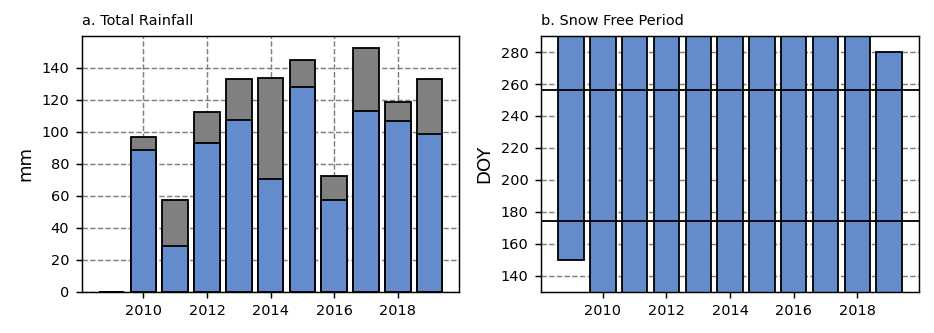

366.0 280.0 365.0
150.0 1.0 1.0


In [119]:

fig,axes = plt.subplots(1,2,figsize=(18.2*cm_2_in, 6.5*cm_2_in),sharex=True)#, 23.7*cm_2_in))


ax = axes[0]

# print(GS_y.index)
GS_y.loc[GS_y.index=='2009-12-31','Rainfall']*= 0
Ann = T30.resample('Y').sum()
Ann.loc[Ann.index=='2009-12-31','Rainfall']*= 0
ax.bar(Ann.index.year,Ann['Rainfall'],edgecolor='k',facecolor = 'grey')
ax.bar(GS_y.index.year,GS_y['Rainfall'],edgecolor='k',facecolor = '#648ccc')
# ax.set_yticks(GS_y.index.year)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

ax.set_ylabel('mm')
ax.set_title('a. Total Rainfall',loc='left')

# Day = T30.copy()
Day = T30.resample('D').mean()
Day['FSDOY'] = Day.index.dayofyear
Day['LSDOY'] = Day.index.dayofyear
Day.loc[Day.index.dayofyear<=200,'LSDOY']=np.nan
Day.loc[Day.index.dayofyear>=200,'FSDOY']=np.nan
Day.loc[Day['snow_cover']>10,'LSDOY']= np.nan
Day.loc[Day['snow_cover']>10,'FSDOY']= np.nan
FS = Day.resample('Y').min()['FSDOY'].values
LS = Day.resample('Y').max()['LSDOY'].values
Y = Day.resample('Y').max().index.year.values

print(LS.max(),LS.min(),np.median(LS))

print(FS.max(),FS.min(),np.median(FS))

ax=axes[1]
ax.set_title('b. Snow Free Period',loc='left')
ax.bar(Y,LS-FS,bottom = FS,edgecolor='k',facecolor = '#648ccc')
# ax.set_yticks(GS_y.index.year)
ax.set_ylim(130,290)
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
# ax.set_yticklabels([])
ax.set_ylabel('DOY')

ax.axhspan(Start,End,-50,10,facecolor='None',edgecolor='k')
plt.tight_layout()

plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Rain_Snow.jpg',dpi=600)

<IPython.core.display.Javascript object>


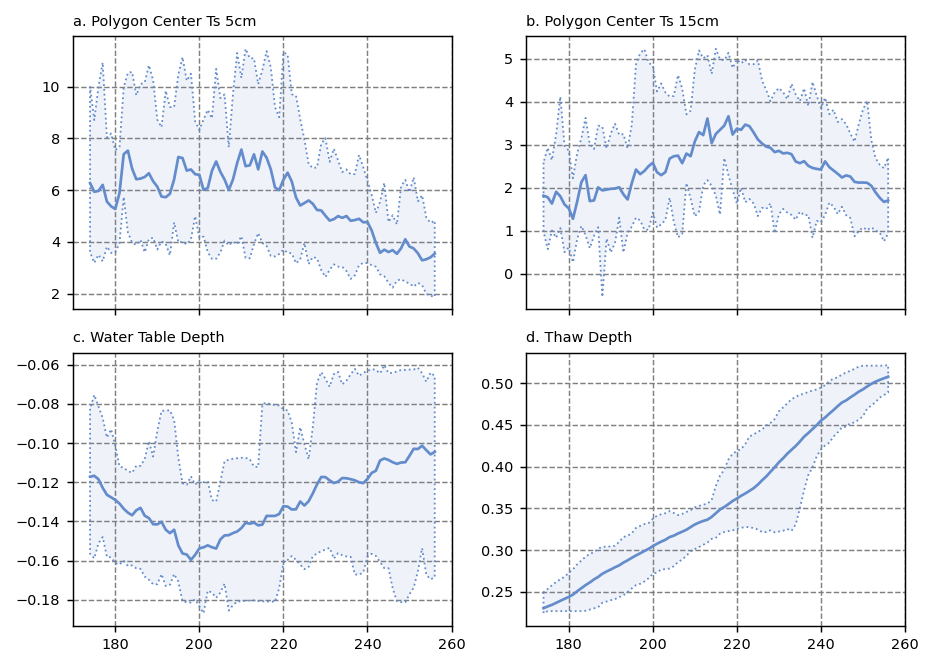

In [120]:
# print((GS_y[['Air_Temp','Rainfall','NR_Wm2_Avg','Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Table_1','Active_Layer_1']].corr()**2).round(2))#,'NR_Wm2_Avg']])


GS_d = GS.groupby(GS.index.dayofyear).mean()
GS_d_mx = GS.groupby(GS.index.dayofyear).max()
GS_d_mn = GS.groupby(GS.index.dayofyear).min()
# print((GS_d[['Air_Temp','Rainfall','NR_Wm2_Avg','Temp_5_1','Temp_5_2','Temp_15_1','Temp_15_2','Table_1','Active_Layer_1']].corr()**2).round(2))#,'NR_Wm2_Avg']])

fig,axes = plt.subplots(2,2,figsize=(18.2*cm_2_in, 13*cm_2_in),sharex=True)


ax = axes[0,0]
ax.plot(GS_d['Temp_5_1'],color='#648ccc')
ax.fill_between(GS_d.index,GS_d_mn['Temp_5_1'],GS_d_mx['Temp_5_1'],facecolor='#648ccc1A',edgecolor='#648ccc',linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('a. Polygon Center Ts 5cm',loc='left')

ax = axes[0,1]
ax.plot(GS_d['Temp_15_1'],color='#648ccc')
ax.fill_between(GS_d.index,GS_d_mn['Temp_15_1'],GS_d_mx['Temp_15_1'],facecolor='#648ccc1A',edgecolor='#648ccc',linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('b. Polygon Center Ts 15cm',loc='left')

ax = axes[1,0]
ax.plot(GS_d['Table_1'],color='#648ccc')
ax.fill_between(GS_d.index,GS_d_mn['Table_1'],GS_d_mx['Table_1'],facecolor='#648ccc1A',edgecolor='#648ccc',linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('c. Water Table Depth',loc='left')

ax = axes[1,1]
ax.plot(GS_d['Active_Layer_1'],color='#648ccc')
ax.fill_between(GS_d.index,GS_d_mn['Active_Layer_1'],GS_d_mx['Active_Layer_1'],facecolor='#648ccc1A',edgecolor='#648ccc',linestyle=':')
ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')
ax.set_title('d. Thaw Depth',loc='left')

plt.tight_layout()

plt.savefig('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Drivers.jpg',dpi=600)

In [121]:
print(GS.resample('Y').max()['Active_Layer_1'].sort_values().round(2))

datetime
2018-12-31    0.49
2013-12-31    0.49
2012-12-31    0.50
2009-12-31    0.50
2014-12-31    0.51
2010-12-31    0.51
2011-12-31    0.51
2019-12-31    0.51
2015-12-31    0.52
2016-12-31    0.52
2017-12-31    0.52
Name: Active_Layer_1, dtype: float64


In [122]:
A = GS.groupby(GS.index.year).mean()[['NEE_est','NME_est']]
print(((A['NME_est']*1e-3)/A['NEE_est']).sort_values())#+A['NME_est']*1e-3))

datetime
2018   -0.056990
2016   -0.054473
2013   -0.052984
2015   -0.051641
2019   -0.047787
2012   -0.045569
2009   -0.044930
2017   -0.044898
2014   -0.044314
2010   -0.044060
2011   -0.042295
dtype: float32


# Annual Correlation (DOY 174-256)

- R2 (w/ sign indicating direction of correlation)

### Non-inputs

## Inputs NEE

In [123]:

V =  ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1',
       'Temp_5_2', 'Temp_15_2','Daytime','ndvi_FIR','Air_Temp']
# T30['ndvi_diff'] = T30['ndvi_FI'].diff(24)
GS = Test.loc[((Test.index.dayofyear>=Start)&(Test.index.dayofyear<=End)&
             (Test.index.year>2008)&(Test.index.year<2020))].copy()

H = GS[V+['NEE_est']].resample('H').mean()
# H['GPP_Sum'] = GS[['GPP_FIR']].resample('H').sum()

# D8 = GS[V+['NEE_est']].resample('8D').mean()
# D['GPP_Sum']8 = GS[V+['NGPP_FIR]].resample('8D').sum()

D = GS[V+['NEE_est']].resample('D').mean()
# D['GPP_Sum'] = GS[['GPP_FIR']].resample('D').sum()

A = GS[V+['NEE_est']].resample('Y').mean()
# A['GPP_Sum'] = GS[['GPP_FIR']].resample('Y').sum()
# V.append('GPP_Sum')

# A['ndvi_FIR']= GS[V+['NEE_est']].resample('Y')['ndvi_FIR'].median()
# (V**2*np.sign(V)).round(2)[:-1].sort_values(by='NEE_est')

# print((GS['NEE_est']-GS['NEE']).diff().max())
# Corrs = (A.corr()[['NEE']].join(D8.corr()[['NEE']],rsuffix='8').join(D.corr()[['NEE']],rsuffix='1').join(H.corr()[['NEE']],rsuffix='H'))[:-1]

# (Corrs**2*np.sign(Corrs)).round(2)

NEE_Corr = {
'Hourly':[],
'Daily':[],
# 'Daily8':[],
'GS':[],
'Hourly_p':[],
'Daily_p':[],
# 'Daily8_p':[],
'GS_p':[]
}
for v in V:
    r = (stats.spearmanr(A['NEE_est'],A[v]))
    
    NEE_Corr['GS'].append(r[0])
    NEE_Corr['GS_p'].append(r[1])
# print()

# for v in V:
#     DNA = D8[['NEE_est',v]].dropna()
#     r = (stats.pearsonr(DNA['NEE_est'],DNA[v]))
    
#     NEE_Corr['Daily8'].append(r[0])
#     NEE_Corr['Daily8_p'].append(r[1])

for v in V:
    DNA = D[['NEE_est',v]].dropna()
    r = (stats.pearsonr(DNA['NEE_est'],DNA[v]))
    
    NEE_Corr['Daily'].append(r[0])
    NEE_Corr['Daily_p'].append(r[1])
        
for v in V:
    DNA = H[['NEE_est',v]].dropna()
    r = (stats.pearsonr(DNA['NEE_est'],DNA[v]))
    NEE_Corr['Hourly'].append(r[0])
    NEE_Corr['Hourly_p'].append(r[1])
    
df = pd.DataFrame(data=NEE_Corr,index=V)
        
V = ['Hourly','Daily','GS']
df[V] = df[V].round(2)

for v in V:
    df.loc[df[v+'_p']>0.05,v]='--'
df[V].to_csv('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Table4.csv')
df[V]

# print(GS['Active_Layer_1'].describe())

,Hourly,Daily,GS
VPD,-0.41,-0.29,--
wind_speed,-0.18,0.13,--
PPFD_Avg,-0.79,-0.67,-0.69
Active_Layer_1,0.49,0.59,--
Temp_5_1,0.03,-0.29,--
Temp_5_2,-0.29,-0.42,--
Temp_15_2,0.35,0.11,--
Daytime,-0.53,-0.63,--
ndvi_FIR,-0.12,-0.31,--
Air_Temp,-0.42,-0.38,--


In [124]:
# print(GS)

In [125]:
V = (T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End)&
        (T30.index.year>=2009)&(T30.index.year<=2018)),
        fch4.Model_Selection.split('+')+['NME_est']
       ].resample('Y').mean().corr()[['NME_est']]).round(4).sort_values(by='NME_est')


V =   ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1','ndvi_FIR','Air_Temp']
GS = Test.loc[((Test.index.dayofyear>=Start)&(Test.index.dayofyear<=End)&
             (Test.index.year>2008)&(Test.index.year<2020))].copy()
H = GS[V+['NME_est']].resample('H').mean()
# D8 = GS[V+['NME_est']].resample('8D').mean()
D = GS[V+['NME_est']].resample('D').mean()
A = GS[V+['NME_est']].resample('Y').mean()
# A['ndvi_FIR']= GS[V+['NEE_est']].resample('Y')['ndvi_FIR'].median()
# (V**2*np.sign(V)).round(2)[:-1].sort_values(

NME_Corr = {
'Hourly':[],
'Daily':[],
# 'Daily8':[],
'GS':[],
'Hourly_p':[],
'Daily_p':[],
# 'Daily8_p':[],
'GS_p':[]
}
for v in V:
    r = (stats.spearmanr(A['NME_est'],A[v]))
    
    NME_Corr['GS'].append(r[0])
    NME_Corr['GS_p'].append(r[1])
# print()

# for v in V:
#     DNA = D8[['NME_est',v]].dropna()
#     r = (stats.pearsonr(DNA['NME_est'],DNA[v]))
    
#     NME_Corr['Daily8'].append(r[0])
#     NME_Corr['Daily8_p'].append(r[1])

for v in V:
    DNA = D[['NME_est',v]].dropna()
    r = (stats.pearsonr(DNA['NME_est'],DNA[v]))
    
    NME_Corr['Daily'].append(r[0])
    NME_Corr['Daily_p'].append(r[1])
        
for v in V:
    DNA = H[['NME_est',v]].dropna()
    r = (stats.pearsonr(DNA['NME_est'],DNA[v]))
    NME_Corr['Hourly'].append(r[0])
    NME_Corr['Hourly_p'].append(r[1])
    
df = pd.DataFrame(data=NME_Corr,index=V)
        
V = ['Hourly','Daily','GS']
df[V] = df[V].round(2)
for v in V:
    df.loc[df[v+'_p']>0.05,v]='--'
df[V].to_csv('G:\\My Drive\\PhD_Thesis\\Chapter3_Figs/Table5.csv')
df[V]

,Hourly,Daily,GS
u*,0.18,--,--
wind_speed,0.11,--,--
NR_Wm2_Avg,0.7,0.72,--
Table_1,-0.39,-0.48,--
Active_Layer_1,-0.75,-0.81,--
Temp_15_1,-0.28,-0.1,--
ndvi_FIR,0.07,0.13,--
Air_Temp,0.48,0.45,--


In [128]:
A = GS[fch4.Model_Selection.split('+')+['Air_Temp','NME_est']].resample('Y').mean()
D8 = GS[fch4.Model_Selection.split('+')+['Air_Temp','NME_est']].resample('8D').mean()
D = GS[fch4.Model_Selection.split('+')+['Air_Temp','NME_est']].resample('D').mean()

GS = T30.loc[((T30.index.dayofyear>=Start)&(T30.index.dayofyear<=End)&
             (T30.index.year>2008)&(T30.index.year<2020))].copy()

H = GS[fch4.Model_Selection.split('+')+['Air_Temp','NME_est']].resample('H').mean()

Corrs = (A.corr()[['NME_est']].join(D8.corr()[['NME_est']],rsuffix='8').join(D.corr()[['NME_est']],rsuffix='1').join(H.corr()[['NME_est']],rsuffix='H'))[:-1]

(Corrs**2*np.sign(Corrs)).round(2)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sign
  if sys.path[0] == '':


,NME_est,NME_est8,NME_est1,NME_estH
u*,-0.00,0.03,0.00,0.03
wind_speed,0.00,0.01,-0.00,0.01
NR_Wm2_Avg,0.07,0.74,0.52,0.49
Table_1,-0.02,-0.23,-0.23,-0.15
Active_Layer_1,-0.00,-0.71,-0.66,-0.56
Temp_15_1,0.06,-0.01,-0.01,-0.08
Polygon,NaN,-0.00,0.00,-0.00
Rim,0.00,-0.00,-0.00,0.00
Air_Temp,0.05,0.30,0.20,0.23


In [129]:
V = (T30.loc[((T30['DOY']>=Start)&(T30['DOY']<=End)&
        (T30.index.year>=2009)&(T30.index.year<=2018)),
        fch4.Model_Selection.split('+')+['NME_est']
       ].resample('Y').mean().corr()[['NME_est']]).round(4).sort_values(by='NME_est')

V**2*np.sign(V).sort_values(by='NME_est')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sign
  


,NME_est
Table_1,-0.067704
u*,-0.048136
wind_speed,-0.025632
Active_Layer_1,-0.001096
Rim,0.000000
NR_Wm2_Avg,0.100046
Temp_15_1,0.178675
NME_est,1.000000
Polygon,NaN


# 8 Day Correlation (Matches resolution of GPP data)

In [130]:
D8 = GS.resample('8D').mean()

D8 = GS[Non_Inputs].resample('8D').mean()
D8['Rainfall'] = GS['Rainfall'].resample('8D').sum()
# D8['ndvi_Max'] = GS['ndvi_FI'].groupby(GS.index.year).sum()

D8 = D8.loc[((D8.index.dayofyear>=Start)&(D8.index.dayofyear<=End)&
        (D8.index.year>=2009)&(D8.index.year<=2018)),Non_Inputs
       ].corr()[['NEE_est','NME_est']][2:]

D8**2*np.sign(D8)

,NEE_est,NME_est
GPP_FI,-0.567991,0.558537
ndvi_FI,-0.220204,0.062346


## Inputs NEE

In [131]:
D8 = GS[fco2.Model_Selection.split('+')+['NEE_est']].resample('8D').mean()
D = GS[fco2.Model_Selection.split('+')+['NEE_est']].resample('D').mean()


D8 = GS[fco2.Model_Selection.split('+')+['NEE_est']].resample('8D').mean()
D8['Rainfall'] = GS['Rainfall'].resample('8D').sum()

D8 = D8.corr()[['NEE_est']].sort_values(by='NEE_est')

(D8**2*np.sign(D8)).round(2)

,NEE_est
Daytime,-0.59
PPFD_Avg,-0.52
Temp_5_2,-0.37
Temp_5_1,-0.31
VPD,-0.26
wind_speed,-0.00
Temp_15_2,-0.00
Rainfall,0.03
Active_Layer_1,0.50
NEE_est,1.00


## Inputs NME

In [132]:
D8 = GS.resample('8D').mean()

D8 = GS[fch4.Model_Selection.split('+')+['NME_est']].resample('8D').mean()
D8['Rainfall'] = GS['Rainfall'].resample('8D').sum()

D8 = D8.corr()[['NME_est']].sort_values(by='NME_est')


D8**2*np.sign(D8)

,NME_est
Active_Layer_1,-0.711818
Table_1,-0.225116
Rainfall,-0.039665
Temp_15_1,-0.005323
Polygon,-0.002062
Rim,-0.000800
wind_speed,0.013134
u*,0.028953
NR_Wm2_Avg,0.738790
NME_est,1.000000


# Daily Correlation

In [133]:
D = GS.resample('D').mean()
# D = GS[fco2.Model_Selection.split('+')+['NEE_est']].resample('D').mean()


D = GS[Non_Inputs].resample('D').mean()
D['Rainfall'] = GS['Rainfall'].resample('8D').sum()

D = D.corr()[['NEE_est','NME_est']][2:]

D**2*np.sign(D)

,NEE_est,NME_est
GPP_FI,-0.328114,0.464777
ndvi_FI,-0.107028,0.025800
Rainfall,0.010684,-0.002783


## Inputs NEE

In [134]:
D = GS[fco2.Model_Selection.split('+')+['NEE_est']].resample('D').mean()

# D = GS[Non_Inputs].resample('D').mean()
# D['Rainfall'] = GS['Rainfall'].resample('8D').sum()


D = D.corr()[['NEE_est']].round(4).sort_values(by='NEE_est')


D**2*np.sign(D)

,NEE_est
PPFD_Avg,-0.447160
Daytime,-0.391000
Temp_5_2,-0.179861
VPD,-0.085498
Temp_5_1,-0.083694
Temp_15_2,0.013202
wind_speed,0.015876
Active_Layer_1,0.346215
NEE_est,1.000000


## Inputs NME

In [135]:
D = GS[fch4.Model_Selection.split('+')+['NME_est']].resample('D').mean()

D = GS[Non_Inputs].resample('D').mean()
D['Rainfall'] = GS['Rainfall'].resample('8D').sum()


D = D.corr()[['NME_est']].round(4).sort_values(by='NME_est')

D**2*np.sign(D)

,NME_est
NEE_est,-0.417445
Rainfall,-0.002788
ndvi_FI,0.025792
GPP_FI,0.464715
NME_est,1.000000
